In [215]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [216]:
%matplotlib inline

In [217]:
main_path = Path.cwd() / ".."

---

In [218]:
# funciones auxiliares
def shift_log(image):
    shifted_image = np.fft.fftshift(image)

    return 20 * np.log(np.abs(shifted_image))

---

##### Cargamos la imagen a usar en los ejercicios y le aplicamos la transformada de Fourier

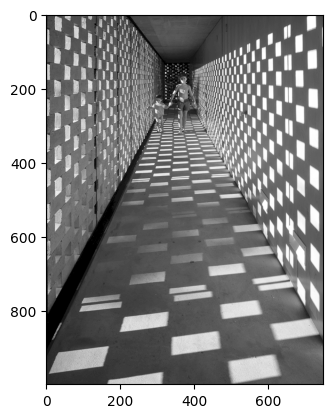

In [219]:
folder_path = main_path / "data"
filename = "pini1.png"
file_path = os.path.join(folder_path, filename)

img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")

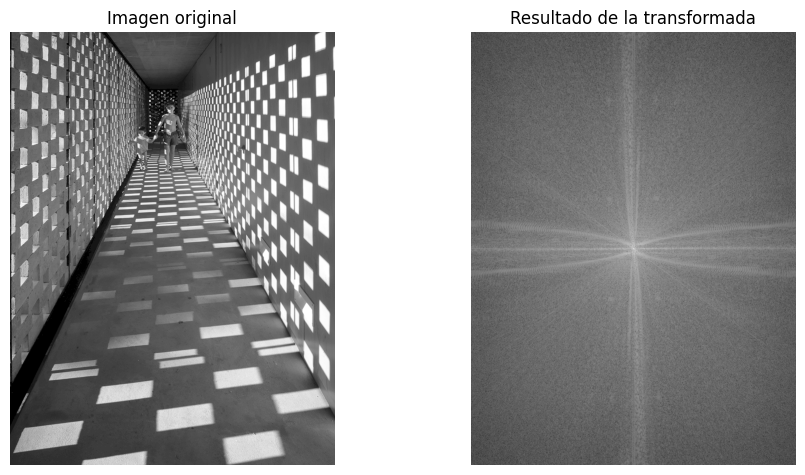

In [220]:
# Aplicamos la transformada
img_tf = np.fft.fft2(img)

# Graficamos
utils.plot_imgs(
    [img, shift_log(img_tf)],
    ["Imagen original", "Resultado de la transformada"],
    "",
    rows=1,
    cols=2,
    is_gray=True,
)

---

##### Ejercicio 0.

Implementar la función create_gauss_filter para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [221]:
def _validate_ksize(ksize):
    is_tuple = isinstance(ksize, tuple)
    if is_tuple:
        is_tuple = all([isinstance(x, int) for x in ksize])
    is_int = isinstance(ksize, int)

    if not is_tuple | is_int:
        raise ValueError("ksize type must be either int or tuple of int")


def _validate_sigma(sigma):
    is_tuple = isinstance(sigma, tuple)
    if is_tuple:
        is_tuple = all([isinstance(x, (int, float)) for x in sigma])
    is_numeric = isinstance(sigma, (int, float))

    if not is_tuple | is_numeric:
        raise ValueError("sigma type must be either int or tuple of int")


def create_gauss_filter(h, w, ksize=5, sigma=5):
    _validate_ksize(ksize)
    _validate_sigma(sigma)

    ksize = ksize if isinstance(ksize, tuple) else (ksize, ksize)
    sigma = sigma if isinstance(sigma, tuple) else (sigma, sigma)

    # Create gaussian kernel
    k_y = cv2.getGaussianKernel(ksize=ksize[0], sigma=sigma[0])
    k_x = cv2.getGaussianKernel(ksize=ksize[1], sigma=sigma[1])

    k = k_y * k_x.T

    # Add padding to match img size
    h_pad_1 = int((h - ksize[0]) / 2)
    h_pad_2 = h - ksize[0] - h_pad_1
    w_pad_1 = int((w - ksize[1]) / 2)
    w_pad_2 = w - ksize[1] - w_pad_1

    k = np.pad(k, [(h_pad_1, h_pad_2), (w_pad_1, w_pad_2)], mode="constant")

    # Apply Fourier Transform
    k_fft = np.fft.fft2(k)

    return k, k_fft

---
##### Ejercicio 1
Graficar ambas representaciones para diferentes tamaños de kernel y sigma.

In [222]:
list_ksizes = [11, 41]
list_sigmas = [3, 9]

list_kernels = []
list_kernels_title = []
for ksize in list_ksizes:
    for sigma in list_sigmas:
        kernel, kernel_tf = create_gauss_filter(100, 100, ksize=ksize, sigma=sigma)

        kernel_title = f"Dominio espacial: kernel size {ksize} - sigma {sigma}"
        kernel_title_tf = f"Dominio espectral: kernel size {ksize} - sigma {sigma}"

        list_kernels.append(kernel)
        list_kernels.append(shift_log(kernel_tf))

        list_kernels_title.append(kernel_title)
        list_kernels_title.append(kernel_title_tf)

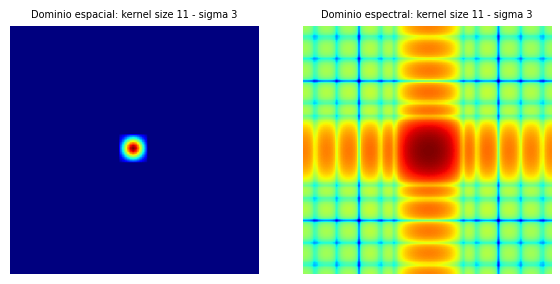

In [223]:
utils.plot_imgs(
    list_kernels[:2],
    list_kernels_title[:2],
    "",
    rows=1,
    cols=2,
    figsize=3,
    is_gray=True,
    cmap="jet",
)

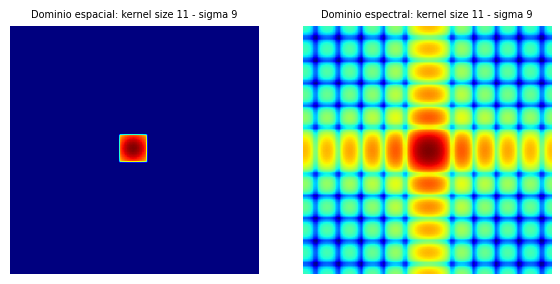

In [224]:
utils.plot_imgs(
    list_kernels[2:4],
    list_kernels_title[2:4],
    "",
    rows=1,
    cols=2,
    figsize=3,
    is_gray=True,
    cmap="jet",
)

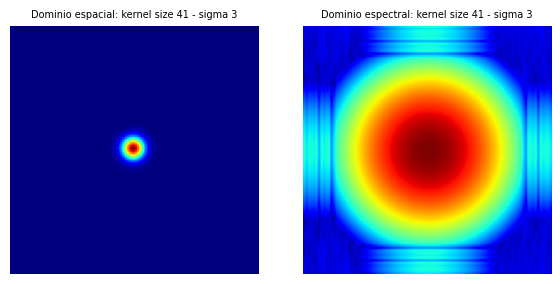

In [225]:
utils.plot_imgs(
    list_kernels[4:6],
    list_kernels_title[4:6],
    "",
    rows=1,
    cols=2,
    figsize=3,
    is_gray=True,
    cmap="jet",
)

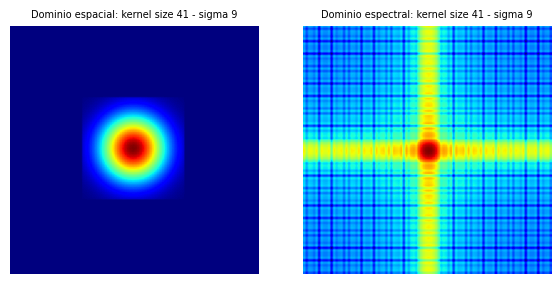

In [226]:
utils.plot_imgs(
    list_kernels[6:8],
    list_kernels_title[6:8],
    "",
    rows=1,
    cols=2,
    figsize=3,
    is_gray=True,
    cmap="jet",
)

Es interesante observar en la representación del dominio espectral de los diferentes kernels que a medida que el tamaño del kernel gaussiano aumenta, al filtrar la imagen original eliminará mayor parte de la alta frecuencia. Esto puede notarse en cuanto disminuye el valor de los pixeles (color azul) hacia los bordes en la imagen que representa el mencionado dominio. Esto tiene sentido si lo pensamos en el dominio espacial, puesto que si aumentamos el tamaño del kernel, al realizar la convolución sucesiva con la imagen original, va a ser mayor la cantidad de píxeles vecinos que produciran el píxel de salida. El efecto visual generado va a ser de una mayor difuminación de la imagen original.

Se destaca también que, a medida que el sigma aumenta, el pico del kernel va a tender a achatarse. Un kernel gaussiano con un pico muy pronunciado (sigma pequeño) va a otorgarle mayor ponderación a los píxeles centrales en la convolución, obteniendo una relativamente baja difuminación. Por el otro lado, un kernel gaussiano con un pico bajo (sigma grande) va a poseer coeficientes más equilibrados generando una difuminación mayor. En un caso extremo, cuando sigma tiende a infinito, el kernel gaussiano va a aproximar a un kernel promediador. Esto puede observarse en el dominio espectral como la disminución del valor de los pixeles correspondientes a frecuencias altas e intermedias, concentrando sus valores mayores hacia el centro de la representación del dominio.

##### Ejercicio 1
Aplicar el filtro a una imagen para validar el funcionamiento en el dominio espectral.

In [227]:
list_ksizes = [11, 41]
list_sigmas = [3, 9]

list_imgs_gauss_tf = []
list_imgs_gauss_title = []
for ksize in list_ksizes:
    for sigma in list_sigmas:
        _, kernel_tf = create_gauss_filter(
            img_tf.shape[0], img_tf.shape[1], ksize=ksize, sigma=sigma
        )

        img_gauss = img_tf * kernel_tf
        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(img_gauss)))

        img_gauss_title = (
            f"Imagen con filtro gaussiano:\nkernel size {ksize} - sigma {sigma}"
        )

        list_imgs_gauss_tf.append(img_gauss)
        list_imgs_gauss_title.append(img_gauss_title)

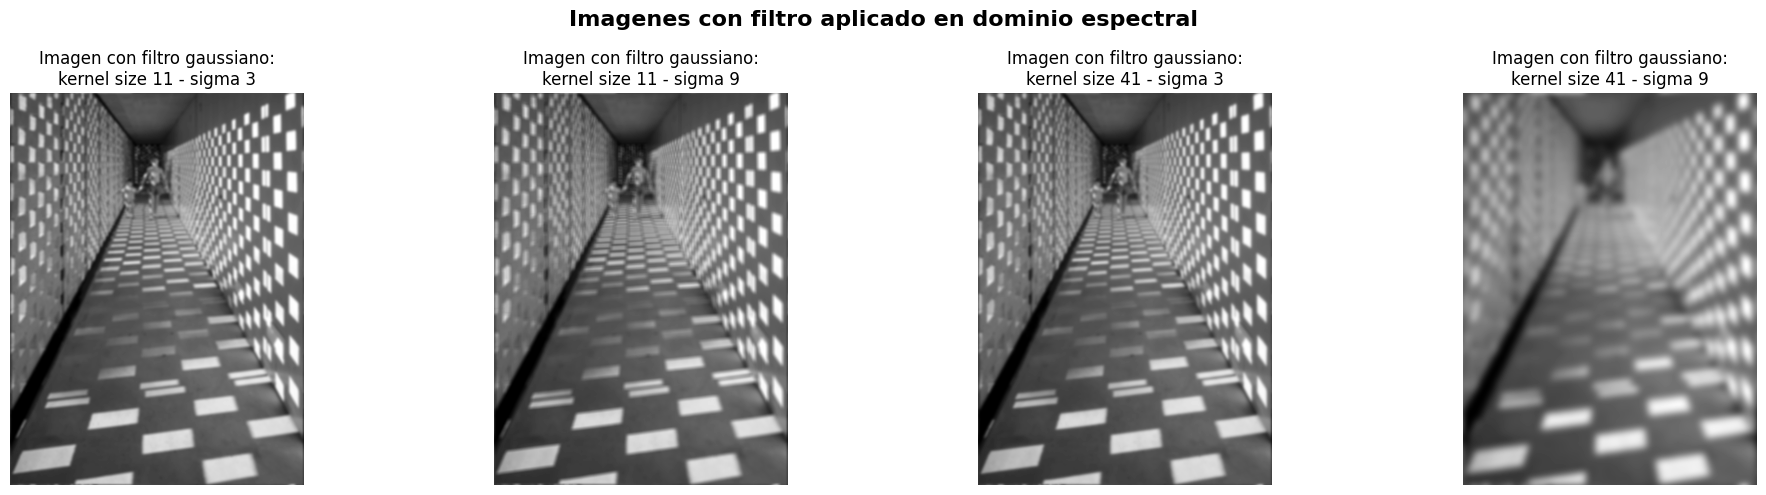

In [228]:
utils.plot_imgs(
    list_imgs_gauss_tf,
    list_imgs_gauss_title,
    "Imagenes con filtro aplicado en dominio espectral",
    rows=1,
    cols=4,
    figsize=5,
    is_gray=True,
    cmap="gray",
)

In [229]:
list_ksizes = [11, 41]
list_sigmas = [3, 9]

list_imgs_gauss = []
for ksize in list_ksizes:
    for sigma in list_sigmas:
        img_gauss = cv2.GaussianBlur(
            img, ksize=(ksize, ksize), sigmaX=sigma, sigmaY=sigma
        )
        list_imgs_gauss.append(img_gauss)

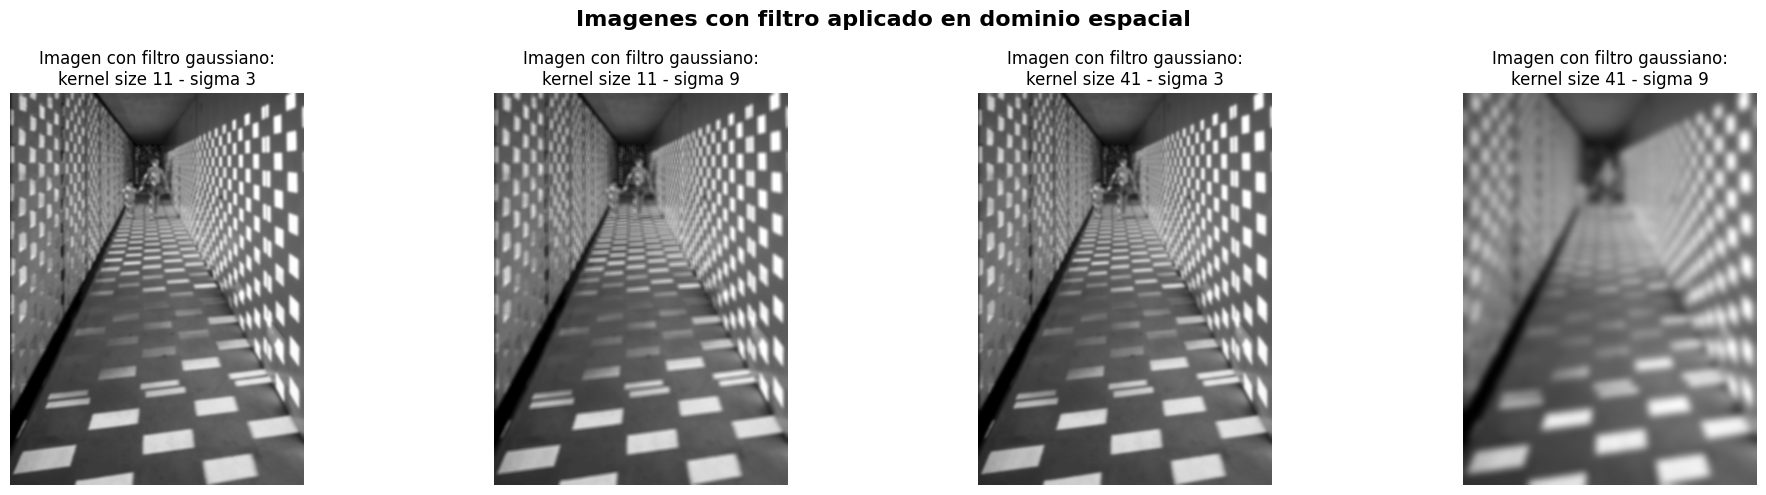

In [230]:
utils.plot_imgs(
    list_imgs_gauss,
    list_imgs_gauss_title,
    "Imagenes con filtro aplicado en dominio espacial",
    rows=1,
    cols=4,
    figsize=5,
    is_gray=True,
    cmap="gray",
)

A primera vista pareciera que los resultados de aplicar el filtro gaussiano, tanto en el dominio espacial como en el espectral, son iguales. A continuación vamos a utilizar métricas para comparar las imágenes y determinar si, efectivamente, el resultado es el mismo.

---
##### Ejercicio 2
Usando el método descripto en el paper 'Image sharpness measure for blurred images in frequency domain' comparar el resultado del filtrado espectral con el filtrado por convolución.

    Frequency domain algorithm:

    - Input: Image I of size MxN.
    - Output: Image quality measure (FM) where FM stands for Frequency Domain.

    1. Compute F which is the Fourier Transform representation of image I.
    2. Find Fc which is obtained by shifting the origin of F to centre.
    3. Calculate AF = abs(Fc) where AF is the absolute value of the centered Fourier transform of image I.
    4. Calculate M = max(AF) where M is the maximum value of the frequency component in F.
    5. Calculate T_H = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    6. Calculate Image Quality measure (FM) from equation:
        FM = T_H / (M*N)

In [231]:
def compute_frequency_domain(I):
    m, n = I.shape

    # Step 1
    F = np.fft.fft2(I)
    # Step 2
    Fc = np.fft.fftshift(F)
    # Step 3
    AF = np.abs(Fc)
    # Step 4
    M = np.max(AF)
    # Step 5
    thres = M / 1000
    T_H = np.sum(F > thres)
    # Step 6
    FM = T_H / (m * n)

    return FM

Comparar para resultados del ejercicio anterior.

In [232]:
for i in range(4):
    print(list_imgs_gauss_title[i], ":")

    FM_conv = compute_frequency_domain(list_imgs_gauss[i])
    FM_tf = compute_frequency_domain(list_imgs_gauss_tf[i])
    print(
        f"Image quality measure para filtrado en dominio espacial: {round(FM_conv, 6)}"
    )
    print(
        f"Image quality measure para filtrado en dominio espectral: {round(FM_tf, 6)}"
    )
    print()

Imagen con filtro gaussiano:
kernel size 11 - sigma 3 :
Image quality measure para filtrado en dominio espacial: 0.002484
Image quality measure para filtrado en dominio espectral: 0.002476

Imagen con filtro gaussiano:
kernel size 11 - sigma 9 :
Image quality measure para filtrado en dominio espacial: 0.002047
Image quality measure para filtrado en dominio espectral: 0.002071

Imagen con filtro gaussiano:
kernel size 41 - sigma 3 :
Image quality measure para filtrado en dominio espacial: 0.002172
Image quality measure para filtrado en dominio espectral: 0.002191

Imagen con filtro gaussiano:
kernel size 41 - sigma 9 :
Image quality measure para filtrado en dominio espacial: 0.000735
Image quality measure para filtrado en dominio espectral: 0.000679



Comparar para diferentes valores de sigma y graficar.

In [233]:
ksize = 11
list_sigmas = np.arange(1.5, 16.5, 1.5)

dict_fm_tf = {}
for sigma in list_sigmas:
    _, kernel_tf = create_gauss_filter(
        img_tf.shape[0], img_tf.shape[1], ksize=ksize, sigma=sigma
    )

    img_gauss = img_tf * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(img_gauss)))

    dict_fm_tf[sigma] = compute_frequency_domain(img_gauss)

dict_fm_conv = {}
for sigma in list_sigmas:
    img_gauss = cv2.GaussianBlur(img, ksize=(ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    dict_fm_conv[sigma] = compute_frequency_domain(img_gauss)

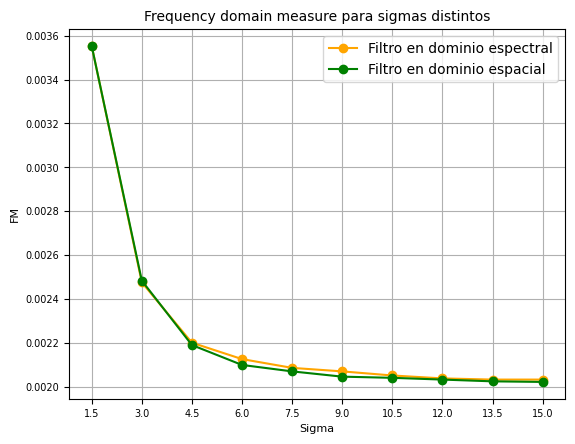

In [234]:
sigmas_tf = list(dict_fm_tf.keys())
fm_tf = list(dict_fm_tf.values())

sigmas_conv = list(dict_fm_conv.keys())
fm_conv = list(dict_fm_conv.values())

plt.plot(
    sigmas_tf, fm_tf, marker="o", color="orange", label="Filtro en dominio espectral"
)
plt.plot(
    sigmas_conv, fm_conv, marker="o", color="green", label="Filtro en dominio espacial"
)

plt.xticks(fontsize=7, ticks=list_sigmas)
plt.yticks(fontsize=7)

plt.xlabel("Sigma", fontsize=8)
plt.ylabel("FM", fontsize=8)
plt.title("Frequency domain measure para sigmas distintos", fontsize=10)
plt.legend()

plt.grid(True)
plt.show()

Cómo intuiamos previamente, a medida que aumentamos el sigma aumenta también la difuminación de la imagen resultante. Podemos ver además que utilizando el método descripto en el paper 'Image sharpness measure for blurred images in frequency domain' obtenemos resultados similares en la evaluación de la difuminación para ambas maneras de aplicar el filtro: en el dominio espacial y en el dominio espectral.

---
##### Ejercicio 3
Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper 'Analysis of focus measure operators in shape-from-focus'.

    Image contrast algorithm:

    Our measure of contrast of an image is the absolute dif-ference of a pixel with its eight neighbors, summed over allthe images of the image.

C(x,y) = $ Σ_{i=x-1}^{x+1} Σ_{j=y-1}^{j+1} |I(x,y) - I(i,j)|$


    where C(x,y) is the image contrast for pixel Iðx,yÞ.

In [206]:
def compute_C(x):
    x_flatten = x.flatten()

    pixel = x_flatten[4]
    neighbors = np.delete(x_flatten, 4)

    C = 0
    for neighbor in neighbors:
        C += abs(pixel - neighbor)

    return C


def compute_image_contrast(img):
    m, n = img.shape

    img = img.astype(float)

    I_C = 0
    for i in range(m):
        for j in range(n):
            pixel = img[i, j]

            y_1 = max(i - 1, 0)
            y_2 = i + 2
            x_1 = max(j - 1, 0)
            x_2 = j + 2
            window = img[y_1:y_2, x_1:x_2]

            # Agregamos padding en los píxeles de borde de la imagen.
            # Se agregan pixeles con valor igual al que se está evaluando para diferencia 0.
            if i == 0:
                window = np.pad(
                    window, [(1, 0), (0, 0)], mode="constant", constant_values=pixel
                )
            elif i == (m - 1):
                window = np.pad(
                    window, [(0, 1), (0, 0)], mode="constant", constant_values=pixel
                )

            if j == 0:
                window = np.pad(
                    window, [(0, 0), (1, 0)], mode="constant", constant_values=pixel
                )
            elif j == (n - 1):
                window = np.pad(
                    window, [(0, 0), (0, 1)], mode="constant", constant_values=pixel
                )

            I_C += compute_C(window)

    return I_C

In [207]:
ksize = 11
list_sigmas = np.arange(1.5, 16.5, 1.5)

dict_fm_tf = {}
for sigma in list_sigmas:
    _, kernel_tf = create_gauss_filter(
        img_tf.shape[0], img_tf.shape[1], ksize=ksize, sigma=sigma
    )

    img_gauss = img_tf * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(img_gauss)))

    dict_fm_tf[sigma] = compute_image_contrast(img_gauss)

dict_fm_conv = {}
for sigma in list_sigmas:
    img_gauss = cv2.GaussianBlur(img, ksize=(ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    dict_fm_conv[sigma] = compute_image_contrast(img_gauss)

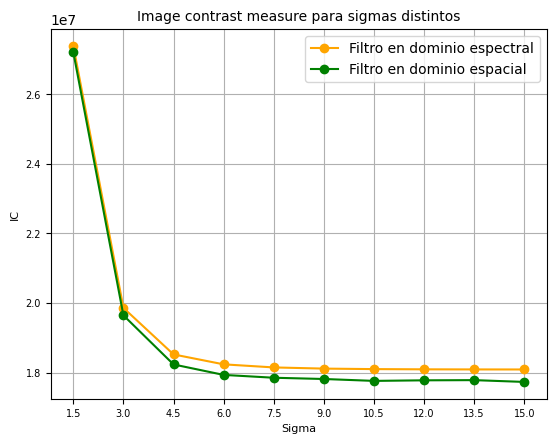

In [214]:
sigmas_tf = list(dict_fm_tf.keys())
fm_tf = list(dict_fm_tf.values())

sigmas_conv = list(dict_fm_conv.keys())
fm_conv = list(dict_fm_conv.values())

plt.plot(
    sigmas_tf, fm_tf, marker="o", color="orange", label="Filtro en dominio espectral"
)
plt.plot(
    sigmas_conv, fm_conv, marker="o", color="green", label="Filtro en dominio espacial"
)

plt.xticks(fontsize=7, ticks=list_sigmas)
plt.yticks(fontsize=7)

plt.xlabel("Sigma", fontsize=8)
plt.ylabel("IC", fontsize=8)
plt.title("Image contrast measure para sigmas distintos", fontsize=10)
plt.legend()

plt.grid(True)
plt.show()

Se observa que al utilizar el algoritmo de image contrast obtenemos resultados que permiten un análisis análogo al realizado con el algoritmo de frequency domain en el ejercicio anterior. Esto es: Que al aumentar el sigma aumenta la difuminación de la imagen, y que la imagen filtrada en ambos dominios obtiene resultados similares.